In [1]:
!pip install -qq transformers

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

I0731 13:31:35.053101 24136 file_utils.py:39] PyTorch version 1.5.0 available.
I0731 13:32:11.899977 24136 file_utils.py:55] TensorFlow version 2.0.0 available.


device(type='cpu')

In [3]:
df = pd.read_csv("reviews.csv")
df.head()

reviewId          userName  \
0  gp:AOqpTOEujjLj56XVqumAkipImEqIAU3qTIuQjENPaOK...      Sam van Dijk   
1  gp:AOqpTOElISilniODwd6UBrqFngzTtDHLF-G0VLpR2_y...      Hugo Bounoua   
2  gp:AOqpTOEkZ75JR5CzVhxoxWa0XVmPanw_pEl1srcJ7yv...  Aishwarya Mishra   
3  gp:AOqpTOEtpLcODD_NZOBqR1N7DBbaLdw3Gyz3v3xZAp1...     Mad Scientist   
4  gp:AOqpTOEqjkdy3-UDym0SAOm2P7Nu6PTnVmLyS1XjwBM...       Joel Haynes   

                                           userImage  \
0  https://lh3.googleusercontent.com/-pO3wTIb4myA...   
1  https://lh3.googleusercontent.com/a-/AOh14GgxG...   
2  https://lh3.googleusercontent.com/a-/AOh14Ghhq...   
3  https://lh3.googleusercontent.com/-kIZF4kMt6yY...   
4  https://lh3.googleusercontent.com/a-/AOh14Gj-j...   

                                             content  score  thumbsUpCount  \
0  Trash. Yes, it has some nice nifty features bu...      1             20   
1  OMG the UI is awful, seriously you have popup ...      1              7   
2  I've been using the app for a while and since ...      1             19   
3  Unable to register with an email. Clicking"con...      1             77   
4  Having to pay to set a recurring task is ridic...      1              1   

  reviewCreatedVersion                   at  \
0             5.2.0.23  2020-07-21 22:17:25   
1             5.2.0.23  2020-07-22 07:23:35   
2             5.2.0.23  2020-07-19 06:49:15   
3              5.2.0.9  2020-07-10 17:59:22   
4             5.2.0.23  2020-07-27 04:50:32   

                                        replyContent            repliedAt  \
0  Premium users can edit, create and delete tags...  2020-07-23 15:57:51   
1  The Premium ad only shows up when first openin...  2020-07-23 16:20:43   
2  Hi, due to new restrictions from Google, the p...  2020-07-22 14:05:56   
3  We are unaware of any issues with signing in t...  2020-07-12 08:02:19   
4                                                NaN                  NaN   

       sortOrder      appId  
0  most_relevant  com.anydo  
1  most_relevant  com.anydo  
2  most_relevant  com.anydo  
3  most_relevant  com.anydo  
4  most_relevant  com.anydo

In [4]:

df.shape

(16070, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16070 entries, 0 to 16069
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              16070 non-null  object
 1   userName              16070 non-null  object
 2   userImage             16070 non-null  object
 3   content               16070 non-null  object
 4   score                 16070 non-null  int64 
 5   thumbsUpCount         16070 non-null  int64 
 6   reviewCreatedVersion  13751 non-null  object
 7   at                    16070 non-null  object
 8   replyContent          7919 non-null   object
 9   repliedAt             7919 non-null   object
 10  sortOrder             16070 non-null  object
 11  appId                 16070 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


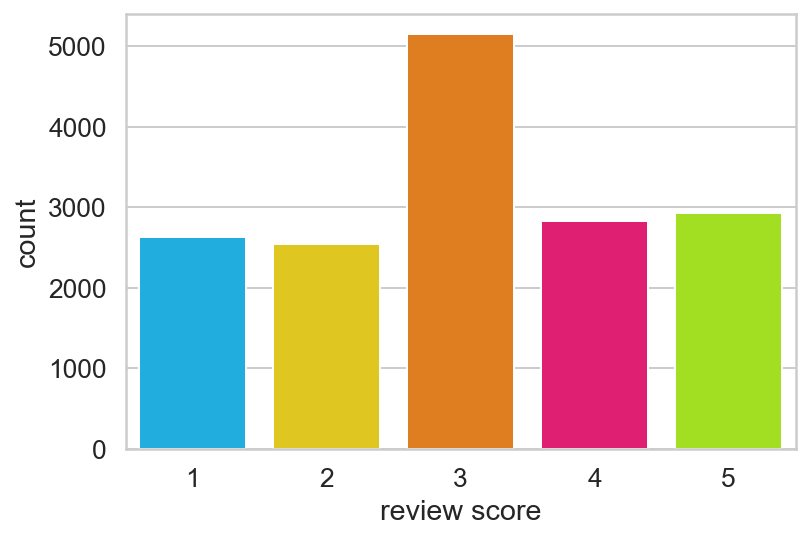

In [6]:

sns.countplot(df.score)
plt.xlabel('review score');

In [7]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [8]:
class_names = ['negative', 'neutral', 'positive']

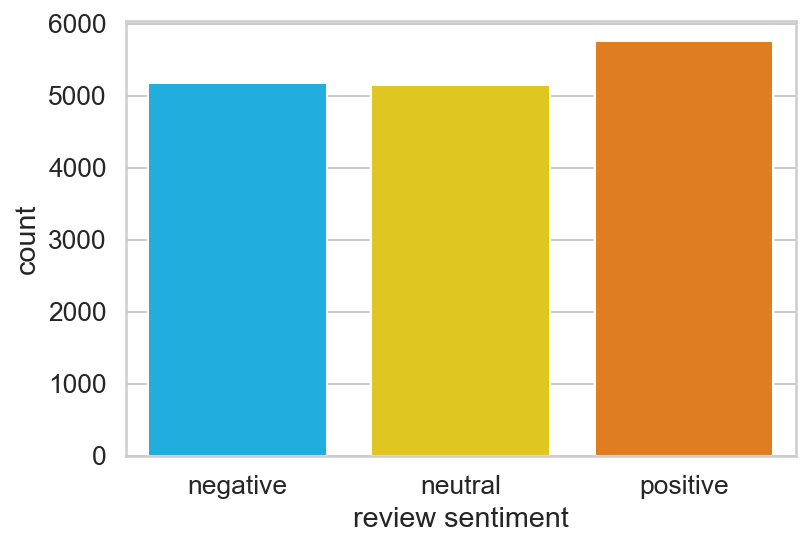

In [9]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [11]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

I0731 13:36:54.972320 24136 filelock.py:274] Lock 2327763333752 acquired on C:\Users\m1049227/.cache\torch\transformers\5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1.lock
I0731 13:36:54.979397 24136 file_utils.py:748] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt not found in cache or force_download set to True, downloading to C:\Users\m1049227\.cache\torch\transformers\tmphpvr9dnz
Downloading: 100%|███████████████████████████████████████████████████████████████████| 213k/213k [00:00<00:00, 320kB/s]
I0731 13:36:56.751070 24136 file_utils.py:752] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt in cache at C:\Users\m1049227/.cache\torch\transformers\5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
I0731 13:36:56.762306 24136 file_utils.py:755] creating meta

In [15]:
sample_txt = 'When. was I last outside? I am stuck at home for 2 weeks.'

In [16]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When. was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', '.', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 119, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [17]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [18]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [19]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [20]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

W0731 13:44:25.233767 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [21]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332,  119, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120,
        1313, 1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [22]:

print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [23]:

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 '.',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [24]:
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

W0731 13:46:07.731414 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:07.744357 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:07.747711 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:07.831238 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:07.841799 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:07.849541 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:07.960791 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:07.972000 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:07.976070 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.087515 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.094073 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.096825 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.153777 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.157150 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.160042 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.221421 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.221421 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.221421 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.271798 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.276400 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.280309 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.358050 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.361036 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.365283 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.413809 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.420783 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.423531 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.482535 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.484699 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.488705 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.551559 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.558903 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.564662 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.662667 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.667443 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.674534 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.756036 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.759976 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.763721 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.837847 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.846552 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.850059 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:08.952814 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.957834 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:08.960819 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:09.067577 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.073777 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.078532 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:09.194355 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.202193 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.205653 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:09.280813 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.283585 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.285817 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:09.365047 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.370815 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.373405 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:09.438353 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.440352 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.444363 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:09.511047 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.513225 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.517221 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:09.592213 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.595095 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.599096 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:09.680015 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.683011 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.686016 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:09.760530 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.765529 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.768534 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:09.828987 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.847205 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.848786 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:09.955087 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.961133 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:09.968551 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:10.093930 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.099571 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.105198 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:10.201261 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.201261 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.211740 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:10.315320 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.324282 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.328747 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:10.416987 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.420757 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.427187 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:10.511651 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.511651 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.523902 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:10.608288 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.612377 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.615491 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:10.700748 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.704262 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.710082 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:10.785586 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.792300 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.795302 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:10.869818 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.875429 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.879137 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:10.963243 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.967865 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:10.970998 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.028294 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.036957 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.049638 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.127267 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.131845 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.135395 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.197807 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.199811 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.201721 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.255479 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.258892 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.261485 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.328143 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.336756 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.342653 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.432794 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.435851 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.443560 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.531275 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.531275 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.540477 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.668959 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.673504 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.680471 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.747433 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.751229 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.755238 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.815428 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.820547 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.824834 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.906232 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.907230 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.912718 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:11.968850 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.972446 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:11.973988 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.050666 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.051668 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.055798 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.119427 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.121992 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.128108 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.196852 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.199848 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.207680 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.272436 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.275753 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.279989 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.341353 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.344354 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.346353 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.414538 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.427560 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.433197 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.513556 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.519144 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.524178 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.601618 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.605042 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.608041 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.677801 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.680800 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.684846 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.744885 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.748169 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.752212 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.811003 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.816316 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.822317 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.873056 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.875851 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.878837 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.936438 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.939608 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:12.942825 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:12.998690 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.002693 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.008902 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.063887 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.067061 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.072112 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.128966 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.131967 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.136014 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.198819 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.202363 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.205239 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.266600 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.272307 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.274878 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.358703 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.362241 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.365993 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.422251 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.425498 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.428965 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.492751 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.498197 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.503852 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.593363 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.598560 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.601861 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.678086 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.680080 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.682907 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.744716 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.749055 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.752975 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.828017 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.830295 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.838009 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:13.935589 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.942285 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:13.945934 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.027971 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.037812 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.040901 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.107381 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.112071 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.115802 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.180063 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.182153 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.187617 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.285901 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.291979 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.294313 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.369600 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.372772 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.376560 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.469787 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.470786 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.475307 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.542511 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.543787 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.548741 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.615751 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.617887 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.620502 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.681289 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.682971 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.685659 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.745469 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.747549 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.753389 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.811494 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.813812 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.816822 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.884190 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.888503 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.895244 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.951130 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.954806 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.958131 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:14.997118 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:14.999122 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.001283 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.101558 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.103314 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.112811 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.213437 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.218065 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.223073 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.296147 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.301558 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.303947 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.368860 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.371645 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.374035 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.434278 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.439012 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.442010 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.494481 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.495730 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.497962 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.546280 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.549560 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.552767 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.602083 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.605477 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.608853 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.667676 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.671220 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.674733 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.742641 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.747415 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.752219 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.821039 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.824657 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.827896 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.893394 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.904481 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.909239 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:15.997541 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:15.998544 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.001682 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.056579 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.059301 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.062747 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.136222 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.137221 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.139981 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.208263 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.211060 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.213117 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.264050 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.266805 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.270010 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.324725 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.324725 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.332162 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.389927 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.394940 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.399447 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.475806 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.476804 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.481108 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.536130 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.536130 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.541286 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.602509 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.605561 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.608600 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.667959 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.672166 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.676456 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.731549 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.736020 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.738673 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.793899 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.798459 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.800784 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.852723 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.854934 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.859081 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.914911 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.917755 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.920755 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:16.967698 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.970700 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:16.973702 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.026214 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.030938 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.035216 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.107741 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.111009 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.116013 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.176832 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.180557 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.184220 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.268024 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.271845 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.280035 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.351009 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.353007 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.356690 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.421851 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.425853 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.429365 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.479898 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.482209 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.485783 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.535305 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.537346 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.538546 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.584188 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.587267 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.591260 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.637733 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.640917 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.644842 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.705943 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.709089 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.713145 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.776010 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.779397 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.782211 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.852691 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.855411 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.857515 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.898787 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.909139 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.912121 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:17.975682 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.979957 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:17.982581 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.054046 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.058814 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.066233 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.144519 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.146519 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.150166 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.217167 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.220063 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.225394 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.273066 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.275219 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.277715 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.339726 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.342725 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.345725 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.396610 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.400292 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.402291 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.476554 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.479552 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.482554 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.574219 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.578885 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.583883 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.650718 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.652715 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.655716 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.727001 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.736166 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.741049 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.818826 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.824538 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.829268 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.890710 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.894728 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.897728 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:18.951405 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.954407 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:18.957406 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.026140 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.031493 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.036492 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.107292 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.110291 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.115289 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.167615 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.171629 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.174632 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.240612 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.245610 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.248610 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.331147 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.340704 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.347772 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.429371 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.433954 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.437182 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.510046 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.513270 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.519619 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.597589 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.612106 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.617991 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.710145 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.714441 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.720347 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.805456 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.812525 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.817568 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.888466 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.893856 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.905289 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:19.963603 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.966877 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:19.970662 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.029899 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.033027 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.037057 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.100814 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.104084 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.107084 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.174582 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.175890 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.179785 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.227419 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.230864 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.233408 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.280259 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.282259 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.286674 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.342501 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.344482 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.349091 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.418674 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.422043 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.426690 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.504257 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.510392 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.510392 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.587625 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.592805 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.592805 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.668307 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.669984 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.674011 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.739032 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.743526 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.745526 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.815320 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.819318 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.821334 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.887742 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.892689 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.895782 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:20.954632 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.957057 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:20.960360 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.025254 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.029510 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.031292 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.108568 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.113074 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.117986 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.176114 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.180143 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.183485 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.236071 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.238097 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.241565 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.329299 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.334983 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.339580 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.398476 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.402121 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.405122 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.460998 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.464374 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.466251 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.519870 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.522339 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.529894 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.581894 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.584918 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.587837 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.645200 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.647549 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.649549 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.707828 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.713157 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.717447 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.792801 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.801077 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.805665 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.857485 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.862196 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.864861 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:21.936779 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.939650 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:21.941600 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.061602 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.071780 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.074698 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.156042 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.161832 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.165486 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.234071 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.240299 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.254154 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.324359 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.328584 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.330582 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.391237 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.394402 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.396612 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.446546 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.449519 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.452633 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.512403 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.514403 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.520581 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.571976 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.578377 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.582781 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.632387 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.635629 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.639692 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.729336 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.733598 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.738025 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.814642 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.818382 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.821656 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.883935 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.886359 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.886359 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:22.944396 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.948363 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:22.951559 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.002435 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.006874 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.010428 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.060634 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.074193 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.078076 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.137175 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.139502 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.142394 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.201675 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.206666 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.209864 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.263230 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.264232 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.273736 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.337140 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.342237 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.347402 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.452687 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.452687 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.464048 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.534003 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.537056 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.542589 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.606489 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.609427 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.612398 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.671666 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.676800 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.681592 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.729515 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.731712 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.735010 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.794393 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.800570 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.804623 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.886396 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.891768 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.898129 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:23.949870 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.954735 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:23.957614 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.027772 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.031907 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.034485 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.090174 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.092438 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.093441 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.167305 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.168961 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.171976 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.242967 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.245681 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.245681 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.335658 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.342254 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.344245 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.454817 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.459972 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.462790 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.548530 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.554703 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.561305 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.633603 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.636640 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.640374 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.701460 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.706258 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.709052 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.759029 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.761068 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.763261 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.813146 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.815397 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.819177 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.878293 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.881294 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.884309 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:24.966691 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.972724 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:24.975720 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.046565 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.050575 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.059514 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.141805 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.149556 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.152760 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.247293 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.250569 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.258551 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.337013 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.341418 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.345418 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.408712 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.412546 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.417995 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.482895 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.489611 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.493966 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.561363 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.567301 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.570538 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.641755 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.648783 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.652782 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.722960 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.727065 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.729073 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.786164 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.791466 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.794466 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.859111 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.862404 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.875510 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:25.951584 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.954957 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:25.956548 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.004697 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.008128 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.011722 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.100749 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.101743 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.112059 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.185975 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.185975 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.198351 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.301041 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.301041 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.313879 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.388927 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.394249 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.397839 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.478507 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.482739 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.488914 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.567023 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.574168 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.576278 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.642886 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.646561 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.650110 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.716436 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.721003 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.722514 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.808925 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.811473 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.818751 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.895415 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.899490 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.902501 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:26.981362 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.986317 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:26.990305 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.060537 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.064520 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.070651 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.128014 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.131623 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.134305 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.196531 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.204512 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.206947 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.271209 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.273803 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.276172 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.335524 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.341477 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.344149 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.404657 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.408671 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.419406 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.484350 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.487082 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.490460 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.559265 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.562732 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.564184 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.640164 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.644078 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.646083 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.707454 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.710523 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.713505 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.768372 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.770941 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.771978 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.836942 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.838941 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.841949 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.890696 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.896048 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.899049 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:27.955010 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.955010 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:27.965204 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.017384 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.020982 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.024065 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.074429 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.079484 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.082480 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.141587 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.144914 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.146938 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.204688 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.204688 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.204688 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.292543 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.296772 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.303874 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.369154 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.377506 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.380676 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.444757 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.446751 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.454196 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.529835 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.534233 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.537410 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.588274 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.590326 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.593016 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.635624 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.639979 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.652887 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.715160 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.718672 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.723070 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.789083 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.795725 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.798722 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.846866 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.849115 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.853151 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.904754 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.908142 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.912526 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:28.980809 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.983385 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:28.986989 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.055036 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.058803 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.059810 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.123783 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.124780 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.133146 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.198253 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.200933 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.202877 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.270497 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.272827 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.275725 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.341230 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.344529 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.346685 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.421363 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.428543 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.432420 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.484122 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.487365 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.491129 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.556235 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.565712 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.569506 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.635668 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.641183 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.645486 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.719704 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.726928 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.732807 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.794323 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.801000 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.811005 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.884539 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.894034 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.898553 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:29.981792 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.983711 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:29.988352 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.043258 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.047817 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.051091 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.103484 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.108904 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.115067 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.167719 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.170782 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.174913 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.233499 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.236626 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.242095 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.296606 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.299711 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.301905 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.345131 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.347890 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.351736 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.418213 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.428430 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.435515 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.495251 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.498185 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.507596 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.570998 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.573983 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.576148 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.640425 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.642469 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.647370 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.717439 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.723549 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.728832 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.808706 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.813897 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.817410 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.886171 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.889114 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.892116 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:30.951739 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.953737 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:30.956235 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.014390 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.017389 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.021393 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.088373 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.094138 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.097137 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.156256 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.160258 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.163640 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.223690 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.227692 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.232456 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.303242 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.306285 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.312284 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.387170 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.393206 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.397205 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.470396 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.477395 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.485394 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.555763 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.563029 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.570419 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.652255 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.659284 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.663281 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.743225 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.746227 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.750226 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.803653 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.806654 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.809651 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.876350 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.878352 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.883348 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.945889 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.948222 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.951597 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:31.989530 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.995576 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:31.998734 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.051467 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.054473 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.057306 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.149785 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.153921 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.155920 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.235890 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.240003 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.243347 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.321561 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.327071 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.333602 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.400912 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.403660 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.406730 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.465138 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.468909 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.472719 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.525223 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.529750 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.534189 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.589667 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.592683 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.594715 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.648683 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.657083 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.667353 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.716225 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.718504 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.718504 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.775543 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.777795 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.778798 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.835855 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.839265 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.842485 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.902810 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.905652 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.908810 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:32.955139 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.960738 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:32.966172 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.008680 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.012688 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.015054 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.051768 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.054897 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.057051 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.100682 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.102942 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.106950 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.160670 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.162744 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.164963 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.231611 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.236784 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.240154 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.305965 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.310852 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.311860 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.388969 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.392764 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.396247 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.466229 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.471147 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.476466 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.546447 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.552034 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.557281 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.666750 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.671964 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.679332 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.762430 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.774261 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.780147 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.869011 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.872610 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.875680 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.924524 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.926137 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.927796 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:33.970039 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.974827 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:33.977824 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.027969 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.031595 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.034645 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.072519 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.072519 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.076478 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.118336 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.122440 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.125163 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.164587 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.171660 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.176167 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.230687 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.233575 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.234581 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.278707 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.279711 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.279711 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.330559 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.334174 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.338216 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.379392 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.380617 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.382616 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.426015 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.428385 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.430514 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.473889 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.484683 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.489210 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.535653 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.537885 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.539620 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.591276 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.592426 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.598771 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.663649 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.667065 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.671908 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.743069 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.750073 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.754718 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.810949 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.812950 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.815053 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.902034 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.907766 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.909943 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:34.983896 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.986501 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:34.989388 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:35.059795 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.067413 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.079740 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:35.335835 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.342942 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.348679 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:35.469554 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.470554 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.479482 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:35.556406 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.559468 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.564388 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:35.633979 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.637814 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.637814 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:35.707499 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.712493 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.717360 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:35.789490 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.795415 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.800743 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:35.863229 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.869349 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.875425 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:35.933263 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.933263 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:35.940562 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:36.029915 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.029915 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.037343 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:36.132499 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.134503 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.134503 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:36.212394 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.217312 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.220327 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:36.300691 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.302690 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.319357 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:36.411240 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.419245 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.427240 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:36.504336 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.504336 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.515827 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:36.576321 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.584323 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.584323 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:36.648185 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.658841 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.658841 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:36.734361 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.737845 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.739850 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:36.805719 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.811255 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.811255 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:36.888216 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.893788 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:36.895825 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:37.010378 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.012529 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.017737 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:37.079931 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.093496 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.101294 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:37.171350 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.175030 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.178976 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:37.283697 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.285581 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.295472 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:37.382236 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.390640 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.392638 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:37.466576 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.472144 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.480635 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:37.591972 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.596675 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.599230 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:37.680363 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.686537 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.692604 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:37.762609 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.767068 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.770065 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:37.863876 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.869473 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.872472 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:37.967151 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.971153 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:37.979620 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:38.080003 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.085823 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.093950 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:38.215773 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.224027 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.229317 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:38.291210 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.291210 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.299157 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:38.401239 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.408579 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.431978 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:38.514353 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.519380 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.522386 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:38.602394 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.618093 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.623672 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:38.709551 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.710551 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.717809 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:38.801141 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.812393 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.813390 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:38.886390 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.893354 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.902392 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:38.988009 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:38.994256 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.003111 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:39.123950 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.124949 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.132985 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:39.222200 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.226366 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.229519 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:39.322436 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.325785 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.329355 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:39.434916 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.436918 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.446105 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:39.531441 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.531441 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.531441 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:39.625283 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.630113 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.633946 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:39.725906 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.730140 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.732802 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:39.837002 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.841304 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.845033 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:39.921238 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.929352 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.933022 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:39.996576 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:39.996576 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.007920 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:40.078595 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.085899 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.087898 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:40.208816 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.218508 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.229195 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:40.335566 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.342402 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.350653 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:40.446100 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.449004 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.452908 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:40.528847 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.529846 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.538105 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:40.612439 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.613441 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.613441 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:40.679334 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.687390 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.687390 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:40.762139 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.762139 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.770196 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:40.844399 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.846412 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.857610 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:40.927663 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.927663 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:40.927663 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.019234 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.020245 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.037448 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.120838 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.126928 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.128921 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.181313 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.192634 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.195634 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.262621 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.265631 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.265631 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.350270 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.357221 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.363675 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.438664 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.438664 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.447762 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.530278 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.535280 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.537837 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.629298 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.634306 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.634306 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.713906 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.716157 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.716157 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.794201 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.794201 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.802229 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.865708 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.868368 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.868368 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:41.948718 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.948718 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:41.956723 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:42.056648 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.063605 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.067057 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:42.162933 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.168108 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.175703 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:42.266753 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.274176 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.276176 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:42.382561 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.386593 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.393296 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:42.465501 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.473500 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.473500 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:42.532810 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.540872 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.540872 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:42.641253 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.642262 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.642262 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:42.717339 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.725392 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.733399 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:42.812811 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.813815 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.820308 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:42.903425 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.906182 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.911327 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:42.984550 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.984550 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:42.992873 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:43.095197 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.105099 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.109260 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:43.208879 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.211095 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.215375 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:43.323631 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.327121 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.331333 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:43.454091 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.460334 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.467355 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:43.566349 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.571086 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.575400 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:43.638808 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.643809 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.646446 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:43.713897 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.716795 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.718937 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:43.772821 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.774690 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.777691 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:43.830491 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.832974 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.837572 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:43.891047 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.894047 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.898915 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:43.966847 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.984190 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:43.989831 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.090716 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.095932 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.102607 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.195279 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.199743 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.203794 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.278030 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.284573 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.290008 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.368004 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.372228 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.376225 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.445119 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.450209 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.454879 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.519294 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.521624 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.524625 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.592937 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.594770 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.598079 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.655990 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.661603 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.665884 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.739112 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.741482 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.743493 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.819251 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.821992 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.825055 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.886628 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.892568 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.893567 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:44.967877 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.971222 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:44.971222 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.036705 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.036705 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.042757 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.123125 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.127413 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.130924 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.193115 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.196478 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.199671 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.253546 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.257963 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.258961 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.326662 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.331592 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.334964 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.373776 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.379064 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.381066 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.439738 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.444392 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.449377 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.532377 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.532377 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.543201 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.607121 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.613776 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.620095 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.699954 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.705989 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.711941 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.782038 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.785307 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.787865 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.832437 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.835396 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.838603 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.881973 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.883973 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.883973 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:45.937659 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.946557 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:45.951628 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.006982 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.012795 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.012795 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.081979 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.087082 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.089603 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.164018 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.175747 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.183497 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.287595 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.293120 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.301259 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.388580 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.394123 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.399832 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.471485 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.473481 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.481535 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.561886 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.570090 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.573644 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.652775 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.653782 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.661746 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.716414 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.716414 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.725549 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.775491 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.780966 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.784227 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.836712 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.840160 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.844046 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.878139 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.879129 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.881097 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.924558 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.927947 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.927947 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:46.971026 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.972141 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:46.973177 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.020729 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.024005 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.027065 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.081957 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.081957 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.081957 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.161971 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.166035 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.172435 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.238456 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.241612 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.247716 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.340315 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.344959 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.347238 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.427259 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.431162 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.434843 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.521844 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.529448 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.529448 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.591984 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.600082 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.600082 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.671906 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.675340 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.677913 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.737345 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.740694 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.740694 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.799526 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.799526 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.807050 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.861002 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.864112 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.867052 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:47.918188 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.923487 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:47.929380 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.008633 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.012837 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.016258 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.093039 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.094041 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.098124 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.141595 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.141595 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.149632 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.212759 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.215634 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.219256 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.273399 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.276628 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.279699 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.325999 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.329001 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.332067 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.381237 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.382866 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.388097 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.430225 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.432536 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.435768 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.481762 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.483762 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.486447 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.535804 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.536806 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.539539 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.580641 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.582452 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.583632 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.637982 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.640979 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.642993 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.687801 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.688843 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.692505 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.736196 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.742709 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.744801 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.792577 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.794552 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.797482 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.846863 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.850778 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.853741 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.901645 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.906055 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.911649 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:48.955783 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.958985 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:48.961934 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.005757 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.009165 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.012504 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.059431 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.063436 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.066064 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.108104 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.111466 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.113718 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.186981 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.190618 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.193686 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.246314 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.246314 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.253401 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.300819 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.307099 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.310115 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.353709 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.355708 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.356709 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.413011 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.423518 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.429126 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.500359 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.504025 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.507994 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.571851 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.572850 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.572850 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.637677 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.641601 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.643604 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.707700 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.709847 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.712924 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.762023 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.765024 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.767024 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.822494 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.826382 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.829852 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.915147 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.920084 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.924668 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:49.992719 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.996152 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:49.999939 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.061403 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.063606 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.068406 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.123194 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.126008 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.128571 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.181861 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.185964 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.187964 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.238155 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.240189 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.242307 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.293542 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.296541 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.298632 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.355322 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.359696 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.361834 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.415520 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.419487 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.423681 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.481172 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.484175 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.487172 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.546322 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.549321 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.552325 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.602821 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.605696 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.608390 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.678241 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.678241 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.682395 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.750563 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.754080 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.758329 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.820679 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.821552 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.824752 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.898125 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.901245 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.902669 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:50.934639 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.944447 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:50.947447 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.002820 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.014791 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.022821 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.090361 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.094484 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.100452 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.176783 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.179302 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.181418 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.247547 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.253408 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.256104 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.335667 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.337668 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.339082 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.388976 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.393282 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.396178 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.456652 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.460348 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.463784 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.525961 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.529679 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.532547 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.579499 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.585838 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.590283 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.637751 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.637751 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.644024 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.690501 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.697144 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.700781 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.762120 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.762120 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.771108 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.822031 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.825868 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.828284 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.873410 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.877561 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.879449 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.936945 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.939319 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:51.943247 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:51.996037 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.000128 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.002346 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.050522 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.050522 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.050522 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.106178 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.108399 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.112406 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.163003 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.167236 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.170044 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.231037 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.234037 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.237174 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.295514 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.297822 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.299824 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.336482 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.338601 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.341255 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.380844 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.382606 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.383602 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.425638 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.432709 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.432709 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.480477 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.483577 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.484578 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.540614 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.546575 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.549729 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.637383 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.640737 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.644734 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.690824 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.693861 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.696359 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.745177 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.746176 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.749355 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.786265 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.793468 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.793468 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.844268 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.844268 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.844268 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.896574 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.896574 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.903614 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.940704 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.947458 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.947975 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:52.984470 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.986279 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:52.988762 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.034107 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.036375 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.038927 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.108303 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.114494 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.120630 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.173917 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.177070 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.179359 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.227500 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.230130 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.233134 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.289497 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.291496 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.293496 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.349482 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.351539 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.351539 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.418760 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.421758 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.423761 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.484342 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.488776 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.492777 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.542316 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.549780 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.549780 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.605820 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.605820 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.617244 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.685685 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.688423 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.688423 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.770086 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.778600 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.780596 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.850192 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.850192 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.857926 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:53.946134 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.951651 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:53.951651 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.059223 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.061225 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.063228 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.118380 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.127799 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.131318 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.197064 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.200063 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.212919 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.261775 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.265034 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.266768 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.306011 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.308130 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.308858 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.356981 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.359265 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.360267 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.413183 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.416584 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.421979 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.472801 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.475167 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.477448 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.530730 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.534093 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.535327 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.573416 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.576424 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.579418 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.627417 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.630064 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.636596 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.686948 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.688158 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.689808 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.726231 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.728846 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.733344 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.787520 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.789832 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.792557 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.839021 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.842654 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.847135 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.886048 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.888244 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.890398 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.925976 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.928132 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.931894 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:54.982397 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.984803 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:54.988321 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.028672 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.030970 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.033382 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.092402 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.094676 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.097190 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.141392 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.145562 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.148020 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.196584 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.199858 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.202855 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.250217 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.252225 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.255209 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.311441 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.316391 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.320688 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.371584 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.372590 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.378557 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.429793 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.433345 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.439688 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.494806 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.496811 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.498720 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.560507 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.564491 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.568039 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.627752 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.630541 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.634541 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.701443 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.711011 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.716274 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.801560 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.804347 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.809637 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.868646 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.871154 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.874903 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.927544 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.930178 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.933532 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:55.988579 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.990581 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:55.994330 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.047209 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.050564 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.052750 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.111732 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.113733 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.116244 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.161253 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.163166 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.165164 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.218213 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.220212 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.223906 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.270863 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.275775 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.277774 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.327990 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.330630 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.334777 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.404272 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.411510 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.415087 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.488803 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.491802 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.496802 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.559079 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.562490 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.564682 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.634632 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.640102 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.645282 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.704491 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.705627 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.708699 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.749668 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.752669 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.755355 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.789984 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.793541 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.799563 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.858053 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.859095 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.861067 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.929196 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.932747 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.936439 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:56.981295 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.982571 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:56.984914 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.018645 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.022229 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.026192 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.068817 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.070701 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.074044 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.113803 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.116088 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.117224 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.158155 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.158155 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.167474 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.249957 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.253476 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.256066 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.322256 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.325884 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.330121 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.384829 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.390442 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.393045 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.435371 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.437633 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.438633 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.466226 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.468229 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.471477 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.524267 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.528046 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.530045 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.595417 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.597689 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.606027 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.659649 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.662187 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.663178 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.715044 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.717977 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.721050 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.768786 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.769788 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.772785 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.825692 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.827260 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.830188 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.891417 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.895350 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.897276 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:57.945572 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.948928 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:57.951877 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.002165 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.003501 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.005653 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.041828 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.043637 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.046397 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.091701 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.092886 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.095521 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.153244 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.155412 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.159508 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.201153 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.204983 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.206861 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.254944 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.257965 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.261159 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.308878 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.312013 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.314085 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.357214 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.358210 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.360421 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.401130 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.409037 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.412173 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.448410 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.451447 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.453097 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.510806 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.514305 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.519149 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.564041 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.565951 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.568427 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.627988 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.630186 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.633241 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.668099 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.669102 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.671111 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.707076 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.710335 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.712121 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.743802 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.745296 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.747193 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.776143 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.778259 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.779294 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.815477 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.816944 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.817948 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.858078 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.859276 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.860858 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.900362 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.906412 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.909415 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.949048 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.950240 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.958991 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:58.993835 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.996039 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:58.997346 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.037223 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.041346 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.042220 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.084773 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.084773 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.084773 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.125714 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.128347 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.130353 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.175865 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.185085 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.187577 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.240712 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.242712 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.246134 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.274451 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.276456 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.278861 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.321946 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.322985 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.325148 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.377848 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.380164 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.386696 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.442418 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.445878 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.448730 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.483913 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.487065 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.491462 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.545119 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.547271 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.548909 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.577276 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.581345 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.588106 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.635213 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.636219 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.639199 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.679618 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.681174 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.683050 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.715600 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.718764 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.721123 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.761738 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.764828 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.766968 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.800100 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.801148 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.802154 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.840314 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.843217 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.846602 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.901126 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.903560 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.908164 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:46:59.982902 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.987169 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:46:59.991774 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.061192 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.066987 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.071441 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.141965 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.145592 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.147727 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.213884 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.218563 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.221320 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.271512 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.274747 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.277071 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.309556 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.311160 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.312524 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.348497 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.350026 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.352006 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.380660 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.382689 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.383651 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.423963 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.426099 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.427863 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.477971 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.480216 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.482331 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.520637 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.523638 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.526089 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.573968 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.576498 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.579962 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.617094 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.619796 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.622389 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.659240 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.667919 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.670195 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.727241 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.729235 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.731618 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.783954 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.786960 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.789047 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.846251 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.848412 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.851235 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.897311 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.900503 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.902591 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:00.950658 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.952678 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:00.955196 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.007981 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.011268 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.017187 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.082173 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.086701 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.090225 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.142583 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.144026 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.147183 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.181928 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.183710 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.186153 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.251855 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.254132 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.256855 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.310287 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.314470 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.315749 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.355257 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.356257 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.357990 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.413355 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.415897 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.418671 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.471956 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.474019 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.477027 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.524233 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.529043 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.531994 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.578549 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.580551 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.582483 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.632995 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.638465 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.642230 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.692409 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.697669 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.702080 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.757120 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.764119 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.770104 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.862361 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.867041 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.871007 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:01.947857 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.950712 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:01.954427 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.020751 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.027022 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.030245 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.086825 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.089359 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.092484 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.137056 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.139981 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.142769 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.187025 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.189432 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.191054 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.232594 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.235911 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.238913 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.282376 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.286023 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.289390 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.357110 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.363056 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.365269 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.434804 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.438473 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.441044 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.496579 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.506850 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.509703 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.568118 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.570377 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.573376 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.633576 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.636575 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.638737 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.698242 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.700239 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.703237 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.756117 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.758885 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.761442 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.827994 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.842992 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.848939 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.895051 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.895051 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.895051 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.941699 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.944468 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.946370 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:02.983698 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.986709 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:02.988714 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.043495 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.044493 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.047485 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.086802 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.088881 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.093005 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.135503 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.137933 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.140801 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.196536 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.198518 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.200946 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.252510 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.254503 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.258083 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.300036 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.301078 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.303018 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.328815 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.329821 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.332325 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.363291 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.364823 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.367931 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.432118 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.433912 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.434917 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.473668 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.475378 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.477349 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.524947 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.529761 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.534631 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.582288 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.584294 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.588490 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.646150 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.649482 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.652982 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.680335 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.688536 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.693741 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.772589 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.776602 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.781908 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.834218 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.835219 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.837139 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.868747 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.873147 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.874152 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.910709 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.911879 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.913184 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:03.959725 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.962308 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:03.962308 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.005960 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.008116 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.010114 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.056437 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.058487 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.061636 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.123862 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.127241 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.131842 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.180439 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.181785 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.183792 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.219912 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.222587 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.224245 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.257883 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.258881 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.260414 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.308210 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.309510 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.312004 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.352845 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.359179 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.361651 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.395593 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.396922 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.398580 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.435642 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.441869 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.443096 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.491666 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.493752 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.495980 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.539325 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.547448 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.552448 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.616350 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.619734 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.625028 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.679183 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.683015 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.687311 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.750827 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.755838 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.762217 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.811296 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.813389 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.817922 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.865413 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.870067 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.873173 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:04.929957 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.936945 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:04.940726 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.008918 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.015346 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.021843 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.084729 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.087459 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.090454 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.153910 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.161080 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.163565 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.226998 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.229000 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.233997 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.288007 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.290003 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.291043 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.347598 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.350576 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.353722 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.414973 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.419598 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.423537 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.468465 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.470929 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.472436 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.512883 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.514671 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.516286 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.565940 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.569537 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.573302 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.621532 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.623355 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.626469 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.664115 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.666231 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.668231 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.715247 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.718878 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.719883 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.771740 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.772889 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.774983 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.812925 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.813887 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.819549 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.851513 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.853325 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.861707 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.908030 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.910547 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.912269 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.950689 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.952329 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.956558 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:05.996558 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:05.998862 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.000590 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.042468 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.044464 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.045410 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.094896 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.095891 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.097524 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.144658 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.147325 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.150083 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.190302 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.192460 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.195147 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.245487 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.249473 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.258228 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.291098 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.293103 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.295165 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.334182 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.335177 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.337877 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.385471 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.387818 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.389900 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.434942 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.435999 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.438103 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.485701 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.487813 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.492836 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.525462 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.528590 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.531351 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.577458 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.579464 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.580463 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.623415 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.625772 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.630075 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.677804 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.681246 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.683832 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.731733 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.733288 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.737040 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.776735 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.778347 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.780347 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.825086 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.827734 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.828778 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.867942 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.870912 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.874779 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.907708 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.909720 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.911700 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.949796 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.951453 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.953659 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:06.988637 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.990294 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:06.991631 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:07.036530 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.036530 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.039592 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:07.075733 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.077839 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.078880 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:07.118319 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.119321 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.121847 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:07.167401 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.169519 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.172709 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:07.213359 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.215339 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.218427 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:07.249525 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.250527 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.252562 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 13:47:07.300777 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.303081 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 13:47:07.305143 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

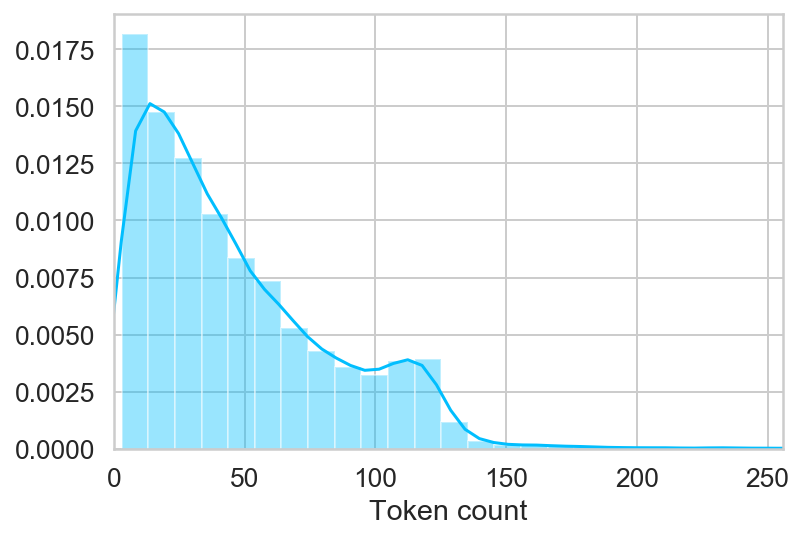

In [25]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [26]:
MAX_LEN = 160

In [27]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

        return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [28]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [29]:
df_train.shape, df_val.shape, df_test.shape

((14463, 13), (803, 13), (804, 13))

In [33]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

In [34]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [35]:
data = next(iter(train_data_loader))
data.keys()

W0731 14:04:54.479037 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:04:54.483153 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:04:54.490961 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [36]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [37]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

I0731 14:05:31.647869 24136 filelock.py:274] Lock 2326181611896 acquired on C:\Users\m1049227/.cache\torch\transformers\b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391.lock
I0731 14:05:31.653887 24136 file_utils.py:748] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json not found in cache or force_download set to True, downloading to C:\Users\m1049227\.cache\torch\transformers\tmpimd5ybqm
Downloading: 100%|████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 47.7kB/s]
I0731 14:05:32.622737 24136 file_utils.py:752] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json in cache at C:\Users\m1049227/.cache\torch\transformers\b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
I0731 14:05:32.639047 24136 file_utils.py:755] creating 

In [38]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [39]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [40]:
bert_model.config.hidden_size

768

In [41]:

pooled_output.shape

torch.Size([1, 768])

In [42]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
        output = self.drop(pooled_output)
        return self.out(output)

In [43]:

model = SentimentClassifier(len(class_names))
model = model.to(device)

I0731 14:07:47.596114 24136 configuration_utils.py:264] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at C:\Users\m1049227/.cache\torch\transformers\b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
I0731 14:07:47.600505 24136 configuration_utils.py:300] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

I0731 14:07:47.698421 24136 modeling_utils.py:667] loading weights file https://cdn.huggingface.co/b

In [44]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [45]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2288, 0.3465, 0.4247],
        [0.1992, 0.4499, 0.3509],
        [0.1557, 0.2688, 0.5754],
        [0.0993, 0.2005, 0.7002],
        [0.1792, 0.4686, 0.3521],
        [0.1056, 0.2665, 0.6279],
        [0.1351, 0.3961, 0.4688],
        [0.1471, 0.3422, 0.5106],
        [0.1501, 0.5079, 0.3420],
        [0.1038, 0.4976, 0.3986],
        [0.1495, 0.4150, 0.4355],
        [0.1466, 0.2898, 0.5636],
        [0.1051, 0.3418, 0.5530],
        [0.1519, 0.5173, 0.3307],
        [0.1495, 0.4875, 0.3630],
        [0.1776, 0.5841, 0.2383]], grad_fn=<SoftmaxBackward>)

In [46]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [47]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [48]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

W0731 14:12:30.131548 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:12:30.136963 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:12:30.142457 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

Epoch 1/5
----------


W0731 14:12:55.086960 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:12:55.090067 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:12:55.096170 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:13:20.957813 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:13:20.967935 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:13:20.973413 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:13:46.971412 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:13:46.976408 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:13:46.980594 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:14:12.959383 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:14:12.964617 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:14:12.971620 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:14:37.968616 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:14:37.973045 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:14:37.975504 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:15:03.178562 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:15:28.645137 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:15:28.652864 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:15:53.870785 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:15:53.872784 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:15:53.880215 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:16:19.207283 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:16:19.210599 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:16:19.217243 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:16:44.400150 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:16:44.407505 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:16:44.416389 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:17:12.541806 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:17:12.550741 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:17:12.562815 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:17:38.867132 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:17:38.873795 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:18:05.461818 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:18:30.714267 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:18:30.722410 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:18:30.731704 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:18:57.909949 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:18:57.916947 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:18:57.920153 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:19:23.416227 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:19:23.426449 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:19:23.433034 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:19:48.631896 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:19:48.657060 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:19:48.664403 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:20:14.887156 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:20:14.893096 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:20:14.900696 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:21:05.048132 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:21:05.055953 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:21:05.065140 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:21:30.722242 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:21:30.730304 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:21:30.740558 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:21:56.304250 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:21:56.309803 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:21:56.312811 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:22:21.757593 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:22:21.762593 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:22:21.767595 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:22:47.832698 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:22:47.832698 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:22:47.842031 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:23:14.071621 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:23:40.240633 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:23:40.250817 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:24:06.213197 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:24:06.222171 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:24:06.222171 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:24:32.336808 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:24:32.347010 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:24:32.347010 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:24:58.413420 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:24:58.418418 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:24:58.426045 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:25:24.627879 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:25:24.627879 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:25:24.637537 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:25:50.341311 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:25:50.344009 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:26:17.749538 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:26:45.034940 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:26:45.042877 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:26:45.042877 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:27:12.229715 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:27:12.245661 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:27:12.252489 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:27:39.006535 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:27:39.011932 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:27:39.015926 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:28:04.714063 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:28:04.721244 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:28:04.725401 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:28:30.410892 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:28:30.415561 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:28:30.418148 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:29:22.426786 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:29:22.434078 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:29:22.441198 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:29:47.295956 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:29:47.301017 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:29:47.308762 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:30:18.450757 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:30:18.454992 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:30:18.462033 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:30:43.497871 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:30:43.504124 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:30:43.514072 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:31:08.713943 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:31:08.716941 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:31:08.721945 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:31:32.980289 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:31:57.591325 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:31:57.598397 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:32:22.566821 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:32:22.574019 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:32:22.580183 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:32:47.454245 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:32:47.458334 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:32:47.461664 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:33:12.958229 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:33:12.963129 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:33:12.969391 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:33:39.092777 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:33:39.095777 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:33:39.099419 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:34:05.110784 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:34:05.118734 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:34:31.331208 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:35:01.010488 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:35:01.018023 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:35:01.028025 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:35:30.763845 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:35:30.768331 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:35:30.774098 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:35:56.793310 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:35:56.799875 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:35:56.811372 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:36:23.144808 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:36:23.182303 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:36:23.225167 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:36:50.315128 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:36:50.321141 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:36:50.324291 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:37:44.267139 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:37:44.271845 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:37:44.277997 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:38:09.478243 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:38:09.487608 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:38:09.498458 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:38:35.087027 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:38:35.093652 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:38:35.100518 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:39:00.960160 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:39:00.971077 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:39:00.981976 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:39:26.063040 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:39:26.069743 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:39:26.079336 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:39:51.303884 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:40:17.781819 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:40:17.791760 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:40:43.742302 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:40:43.742302 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:40:43.751738 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:41:09.485973 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:41:09.491309 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:41:09.496147 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:41:34.820382 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:41:34.824616 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:41:34.829620 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:41:59.772430 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:41:59.781086 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:41:59.785421 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:42:23.921893 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:42:23.930387 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:42:49.714423 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:43:15.961062 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:43:15.968804 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:43:15.975620 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:43:42.115220 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:43:42.123524 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:43:42.129518 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:44:06.805790 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:44:06.808048 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:44:06.813742 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:44:33.035570 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:44:33.045319 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:44:33.053466 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:44:59.086492 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:44:59.091839 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:44:59.097501 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:45:50.289621 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:45:50.296868 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:45:50.307651 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:46:15.716784 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:46:15.717808 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:46:15.728158 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:46:40.286612 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:46:40.286612 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:46:40.298962 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:47:06.109571 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:47:06.115915 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:47:06.128791 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:47:32.222297 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:47:32.227390 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:47:32.229411 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:47:58.426329 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:48:23.466418 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:48:23.472240 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:48:49.319817 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:48:49.326853 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:48:49.331993 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:49:15.949310 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:49:15.958575 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:49:15.967707 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:49:41.516397 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:49:41.519419 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:49:41.519419 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:50:07.941430 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:50:07.951135 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:50:07.957001 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:50:33.445068 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:50:33.452571 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:50:58.765751 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:51:24.407665 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:51:24.413285 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:51:24.416501 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:51:50.174162 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:51:50.185301 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:51:50.185301 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:52:15.745611 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:52:15.746593 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:52:15.756657 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:52:41.350037 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:52:41.357606 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:52:41.361396 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:53:07.036976 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:53:07.046740 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:53:07.047742 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:53:56.173045 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:53:56.182005 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:53:56.187577 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:54:21.150394 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:54:21.156077 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:54:21.161057 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:54:45.740408 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:54:45.750871 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:54:45.760548 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:55:11.547626 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:55:11.551993 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:55:11.560119 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:55:37.286717 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:55:37.291572 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:55:37.296021 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:56:02.092420 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:56:27.286646 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:56:27.296666 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:56:53.196523 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:56:53.205366 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:56:53.206363 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:57:19.141416 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:57:19.145415 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:57:19.151472 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:57:44.280475 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:57:44.284476 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:57:44.294698 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:58:10.827101 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:58:10.833760 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:58:10.840930 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:58:36.178958 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:58:36.188345 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:59:02.003614 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:59:27.986341 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:59:27.992594 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:59:27.997594 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 14:59:53.912391 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:59:53.919646 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 14:59:53.922187 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:00:19.666998 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:00:19.675485 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:00:19.683645 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:00:45.416996 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:00:45.429153 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:00:45.436406 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:01:11.927500 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:01:11.931048 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:01:11.935877 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:02:01.842705 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:02:01.849069 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:02:01.856647 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:02:26.712972 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:02:26.720419 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:02:26.724372 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:02:52.792560 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:02:52.798022 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:02:52.804355 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:03:17.291934 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:03:17.299398 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:03:17.308677 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:03:42.386830 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:03:42.388840 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:03:42.393950 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:04:07.776437 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:04:33.161875 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:04:33.171123 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:04:58.998396 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:04:59.004277 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:04:59.009768 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:05:24.636593 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:05:24.644044 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:05:24.648806 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:05:50.527108 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:05:50.531097 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:05:50.539670 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:06:15.617867 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:06:15.623470 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:06:15.626594 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:06:41.326383 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:06:41.333368 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:07:06.541218 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:07:32.495063 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:07:32.499594 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:07:32.505115 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:07:58.548613 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:07:58.558017 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:07:58.559600 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:08:24.395802 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:08:24.401830 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:08:24.405624 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:08:50.295443 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:08:50.304427 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:08:50.310795 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:09:15.546769 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:09:15.557144 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:09:15.562167 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:10:06.463208 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:10:06.470754 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:10:06.476868 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:10:31.446045 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:10:31.450041 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:10:31.454084 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:10:54.686826 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:10:54.691652 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:10:54.692641 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:11:20.352986 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:11:20.357542 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:11:20.363073 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:11:46.222176 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:11:46.226646 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:11:46.231051 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:12:11.176777 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:12:36.314110 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:12:36.320723 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:13:01.466081 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:13:01.470713 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:13:01.478448 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:13:26.658716 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:13:26.666715 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:13:26.675558 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:13:51.819604 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:13:51.827316 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:13:51.831612 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:14:17.122922 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:14:17.127924 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:14:17.132152 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:14:42.858682 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:14:42.864291 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:15:07.943969 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:15:33.229147 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:15:33.235696 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:15:33.237695 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:15:58.709070 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:15:58.715881 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:15:58.721123 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:16:23.729602 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:16:23.735386 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:16:23.739945 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:16:49.353520 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:16:49.357593 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:16:49.361678 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:17:14.493268 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:17:14.501664 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:17:14.505664 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:18:04.734483 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:18:04.739621 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:18:04.745621 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:18:30.389936 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:18:30.394036 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:18:30.397147 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:18:55.100293 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:18:55.105679 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:18:55.111742 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:19:20.198684 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:19:20.208260 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:19:20.213258 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:19:47.130999 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:19:47.136016 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:19:47.139002 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:20:01.737720 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:20:14.142719 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:20:14.145717 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:20:26.925720 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:20:26.929723 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:20:26.931720 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:20:39.796850 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:20:39.798852 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:20:39.800852 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:20:52.834849 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:20:52.837847 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:20:52.839848 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:21:11.791431 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:21:11.795433 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:21:11.801433 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:21:28.098433 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:21:28.103431 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:21:43.081039 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

W0731 15:21:57.449039 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:21:57.451041 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
W0731 15:21:57.454037 24136 tokenization_utils_base.py:1447] Truncation was not explicitely activated but `max_length` is provid

KeyboardInterrupt: 